**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

*Based on the structure in JV-calibration-deterministic-provinces*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import datetime
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD, moving_avg
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, lockdown_func, policies_until_september

from covid19model.optimization.objective_fcns import MLE, ll_poisson

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Get public data

In [2]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=True)

In [3]:
raw_hosp_data = pd.read_csv('../../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
timeseries_H_in_national = pd.pivot_table(raw_hosp_data, values='NEW_IN', index='DATE', aggfunc=np.sum)

Hainaut_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Hainaut']
Hainaut_ts = Hainaut_hosp_data[['DATE','NEW_IN']].set_index('DATE')
timeseries_H_in_hainaut = Hainaut_ts[['NEW_IN']]

<IPython.core.display.Javascript object>


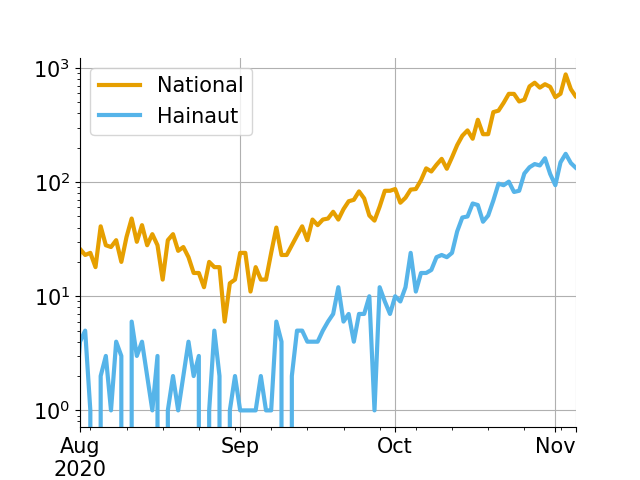

(18475, 18571)

In [4]:
fig,ax = plt.subplots()
timeseries_H_in_national.reset_index().plot('DATE','NEW_IN', logy=True, ax=ax, label='National')
timeseries_H_in_hainaut.reset_index().plot('DATE', 'NEW_IN', logy=True, ax=ax, label='Hainaut')
ax.set_xlim('2020-08-01', '2020-11-05')

# Load contact and geographic data

In [5]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')

# Define the number of age categories
levels = initN.size
province_names = pd.read_csv('../../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../../data/interim/demographic/initN_prov.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[50000].iloc[:9]))

In [7]:
# Output for calibration
fig_path = '../../results/calibrations/COVID19_SEIRD/provinces/'
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/provinces/'

# Model initialisations

## Jenna's original code for the national model

In [15]:
### FIRST WAVE ONLY (NO ADDITIONAL POLICIES)

# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params_wave1 = model_parameters.get_COVID19_SEIRD_parameters()
params_wave1.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')}) # Start of lockdown
# Usage:
initial_states = {'S': initN, 'E': np.ones(levels)}

# lockdown_func should be a global variable in multicore processing
global lockdown_func
model_wave1 = models.COVID19_SEIRD(initial_states, params_wave1, time_dependent_parameters={'Nc': lockdown_func})

In [9]:
### ALL MEASURES UNTIL SEPTEMBER

# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params_until_sept = model_parameters.get_COVID19_SEIRD_parameters()

params_until_sept.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.25)*Nc_transport + (1-0.05)*Nc_others + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + (1-0.40)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date':pd.to_datetime('2020-03-15')})

# Usage:
initial_states = {'S': initN, 'E': np.ones(levels)}
model_wave1_with_policies = models.COVID19_SEIRD(initial_states, params_until_sept, time_dependent_parameters={'Nc': policies_until_september})

# Plotfunctions

In [10]:
### DEFINE FUNCTION TO PLOT THE RESULT OF THE SIMULATION
# this should probably go in the optimization.visualization module as well

def plot_simulations(start_date, end_ramp, end_date, model, samples_dict, timeseries, 
                    spatial_unit, n_lines=200, save=False):

    states = [['H_in']]
    data=[timeseries[start_date:end_ramp].values]

    fig,ax=plt.subplots()
    for i in range(n_lines):
        idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
        if 'l' in model.parameters.keys():
            idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
            model.parameters['tau'] = samples_dict['tau'][idx] # idx takes the same index
            model.parameters['prevention'] = samples_dict['prevention'][idx]
        y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
        ax = plot_fit(y_model,data,start_date,samples_dict['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
    
    # plot mean line
    model.parameters['beta'] = np.mean(samples_dict['beta'])
    if 'l' in model.parameters.keys():
        model.parameters['l'] = np.mean(samples_dict['l'])
        model.parameters['tau'] = np.mean(samples_dict['tau'])
        model.parameters['prevention'] = np.mean(samples_dict['prevention'])
    y_model = model.sim(time=end_date, warmup=samples_dict['warmup'], start_date=start_date)
    ax.plot(y_model['time'],y_model['H_in'].sum(dim='Nc'), c='green', linestyle='--', lw=2, alpha=0.5)
    
    data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
    plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
    legend_text=['daily \nhospitalizations']
    ax.set_xlim(start_date, end_date)
    fig.tight_layout()
    if save==True:
        fig.savefig(fig_path+spatial_unit +'_'+str(datetime.date.today())+'.pdf',bbox_inches='tight', dpi=600)
    return

# Calibration on first wave

In [16]:
data_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_prov.csv'
raw_data = pd.read_csv(data_file, sep=',', header=0,  parse_dates = ['DATE'])
raw_data.fillna(0, inplace=True)
data = pd.pivot_table(raw_data, index='DATE', values='hospitalised_IN', aggfunc=np.sum)
timeseries = moving_avg(data,dropna=True)
timeseries.rename(columns={'hospitalised_IN' : 'H_in'}, inplace=True)

timeseries

,H_in
DATE,
2020-03-05,25.571429
2020-03-06,29.714286
2020-03-07,35.142857
2020-03-08,42.142857
2020-03-09,52.714286
...,...
2020-11-18,66.142857
2020-11-19,56.714286
2020-11-20,40.428571


**Manually scouting for good `warmup` and `beta` values**

Remark: beta is currently found using a model that already implements measures. Make sure to cut it off sufficiently early so these measures are not yet seen in the data/model, or it might disrupt the calculation of the beta.

_idea_ Shouldn't it be better to try to fit a model without any kind of measures? I can certainly do this.

<IPython.core.display.Javascript object>


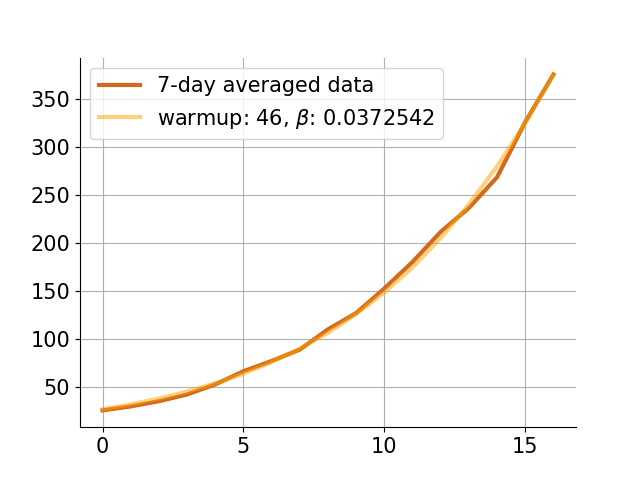

In [17]:
## SCRATCHES

warmup = 46 # 45
beta = 0.0372542 # 0.0372542
start_date = '2020-03-05'
end_beta = '2020-03-21'
ts = timeseries[start_date:end_beta].squeeze().values

plt.close()
plt.plot(ts,color='chocolate',label='7-day averaged data')

betas = np.linspace(0.037, 0.039, 100)
warmups = np.linspace(40, 50, 11)

# for beta in betas[:-1]:
#     model_wave1.parameters.update({'beta' : beta})
#     out = model_wave1.sim(int(len(ts)+warmup-1), start_date=start_date, warmup=warmup)
#     plt.plot(out['H_in'].sum(dim='Nc')[warmup:], color='orange',alpha=0.1)

model_wave1.parameters.update({'beta' : beta})
out = model_wave1.sim(int(len(ts)+warmup-1), start_date=start_date, warmup=warmup)
plt.plot(out['H_in'].sum(dim='Nc')[warmup:], color='orange', alpha=.5,label=f'warmup: {warmup}, $\\beta$: {beta}')
    
plt.legend()
plt.show()

**Verify that avoiding the zero-point of the Poisson distribution doesn't significantly affect the extremum's location**

<IPython.core.display.Javascript object>


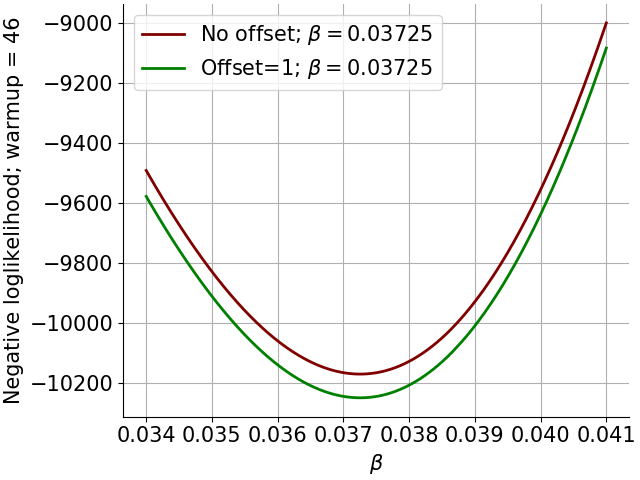

In [29]:
betas = np.linspace(0.034, 0.041, 300)
warmups = np.linspace(40, 50, 11)

# MLEs = []
# MLEs_offset = []
# for beta in betas:
#     thetas = [warmup, beta]
#     states = [['H_in']]
#     parNames = ['warmup','beta']
#     value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=0)
#     MLEs.append(value)
#     value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=1)
#     MLEs_offset.append(value)

no_offset_max = round(betas[MLEs.index(min(MLEs))],5)
offset_max = round(betas[MLEs_offset.index(min(MLEs_offset))],5)
    
plt.close()
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(betas, MLEs, color='maroon', linewidth=2, label=f'No offset; $\\beta = {no_offset_max}$')
ax1.plot(betas, MLEs_offset, color='green', linewidth=2, label=f'Offset=1; $\\beta = {offset_max}$')
plt.xlabel(r'$\beta$')
plt.ylabel(f'Negative loglikelihood; warmup = {warmup}')
plt.legend()
plt.show()

# print(f'-----------------------------------')
# print(f'beta when no offset: {no_offset_max}')
# print(f'beta when offset=1:  {offset_max}')

<IPython.core.display.Javascript object>


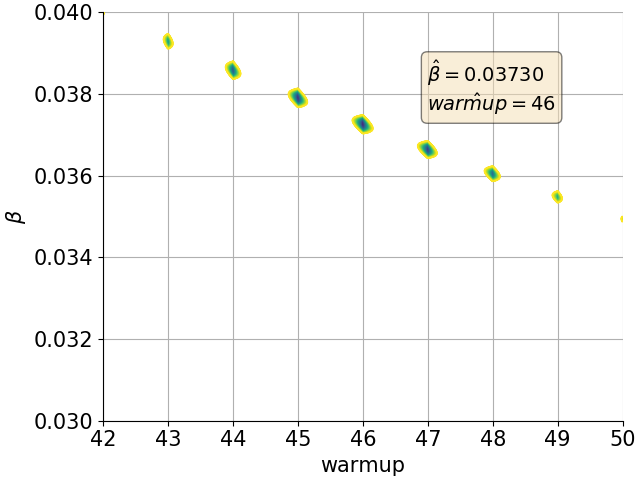

Minimal loglikelihood value: -10171.0 (goal value of PSO)
Maximal loglikelihood value: -6224.0


In [39]:
betas = np.linspace(0.030, 0.040, 300)
warmups = np.linspace(42, 50, 9)
threshold = 4

# MLEs_grid = np.zeros([len(betas), len(warmups)])
# for j, wu in enumerate(warmups):
#     for i, beta in enumerate(betas):
#         thetas = [int(wu), beta]
#         states = [['H_in']]
#         parNames = ['warmup','beta']
#         value = MLE(thetas, model_wave1, [ts], states, parNames, start_date=start_date,poisson_offset=0)
#         MLEs_grid[i,j] = value
    
plt.close()
lines = np.linspace(np.min(MLEs_grid), np.min(MLEs_grid)+threshold, 101)
fig, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contour(warmups, betas, MLEs_grid, lines, linewidths=1)
# plt.xlim([np.min(warmups)-1, np.max(warmups)+1])
plt.xlabel(f'warmup')
plt.ylabel(f'$\\beta$')

beta_min = round(betas[np.unravel_index(np.argmin(MLEs_grid),MLEs_grid.shape)[0]],4)
warmup_min = int(warmups[np.unravel_index(np.argmin(MLEs_grid),MLEs_grid.shape)[1]])

textstr = '\n'.join((
    r'$\hat{\beta} = %.5f$' % (beta_min, ),
    r'$\hat{warmup} = %.0f$' % (warmup_min, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = ax2.text(0.70, 1, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

print(f'Minimal loglikelihood value: {round(np.min(MLEs_grid),0)} (goal value of PSO)')
print(f'Maximal loglikelihood value: {round(np.max(MLEs_grid),0)}')

In [27]:
# Here the PSO works just fine.

from covid19model.optimization import pso

start_date = '2020-03-05'
parNames_pso = ['warmup','beta']
bounds_pso=((42,50),(0.030,0.040))
states = [['H_in']]

theta = pso.fit_pso(model,data,parNames_pso,states,bounds_pso,maxiter=maxiter,popsize=popsize,
                start_date=start_date, omega=omega, phip=phip, phig=phig)

# theta = pso.fit_pso(model_wave1,[ts],parNames_pso, states, bounds_pso, maxiter=100, popsize=50, start_date=start_date)

No constraints given.
Best after iteration 1: [4.66941261e+01 3.66849113e-02] -10170.29028648252
Best after iteration 2: [4.66941261e+01 3.66849113e-02] -10170.29028648252
New best for swarm at iteration 3: [4.62467972e+01 3.72228810e-02] -10170.706332617769
Best after iteration 3: [4.62467972e+01 3.72228810e-02] -10170.706332617769
New best for swarm at iteration 4: [4.60579095e+01 3.72442023e-02] -10170.773060602469
Best after iteration 4: [4.60579095e+01 3.72442023e-02] -10170.773060602469
Best after iteration 5: [4.60579095e+01 3.72442023e-02] -10170.773060602469
Best after iteration 6: [4.60579095e+01 3.72442023e-02] -10170.773060602469
New best for swarm at iteration 7: [4.61380366e+01 3.72457909e-02] -10170.775338209867
Best after iteration 7: [4.61380366e+01 3.72457909e-02] -10170.775338209867
Best after iteration 8: [4.61380366e+01 3.72457909e-02] -10170.775338209867
New best for swarm at iteration 9: [4.58084448e+01 3.72544017e-02] -10170.781173760288
Best after iteration 9: 

In [20]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-21'
end_ramp = '2020-05-23'#'2020-05-23'

In [21]:
len(Hainaut_ts.loc[start_date:end_beta])

7

In [22]:
len(Hainaut_ts.loc[end_beta:end_ramp])

64

In [23]:
from multiprocessing import Pool

In [26]:
spatial_unit = 'test_poisson'

# samples_dict = full_calibration_wave1(model_wave1, timeseries_H_in_hainaut, spatial_unit, start_date, end_beta, end_ramp, 
#                                 fig_path=fig_path, samples_path=samples_path,
#                                 initN=initN, Nc_total=Nc_total,
#                                 maxiter=100, popsize=500, steps_mcmc=1000)#popsize increased to 500

samples_dict = full_calibration_wave1(model_wave1, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=100, popsize=50, steps_mcmc=10, discard=0)#popsize increased to 500

[array([ 25.57142857,  29.71428571,  35.14285714,  42.14285714,
        52.71428571,  66.42857143,  77.14285714,  89.        ,
       110.14285714, 127.14285714, 152.71428571, 180.42857143,
       211.85714286, 236.71428571, 268.85714286, 326.42857143,
       376.        ])]
Using all but one logical processors

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [4.59730858e+01 3.70850229e-02] -10168.661129256521
Best after iteration 2: [4.59730858e+01 3.70850229e-02] -10168.661129256521
Best after iteration 3: [4.59730858e+01 3.70850229e-02] -10168.661129256521
New best for swarm at iteration 4: [4.53439593e+01 3.79318054e-02] -10170.616517389668
Best after iteration 4: [4.53439593e+01 3.79318054e-02] -10170.616517389668
Best after iteration 5: [4.53439593e+01 3.79318054e-02] -10170.616517389668


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


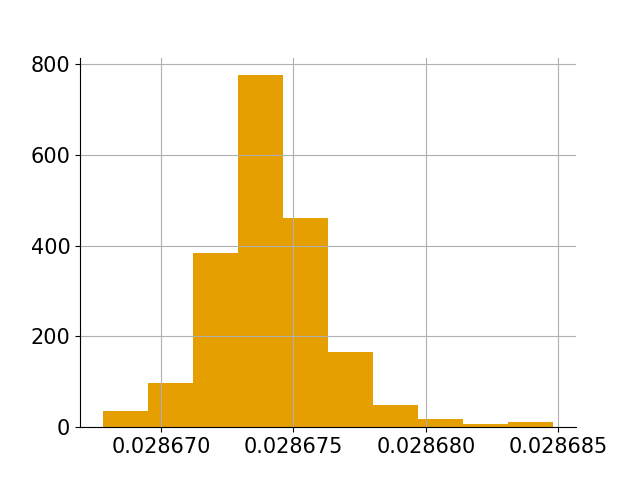

In [16]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [17]:
samples_dict['warmup']

30

<IPython.core.display.Javascript object>


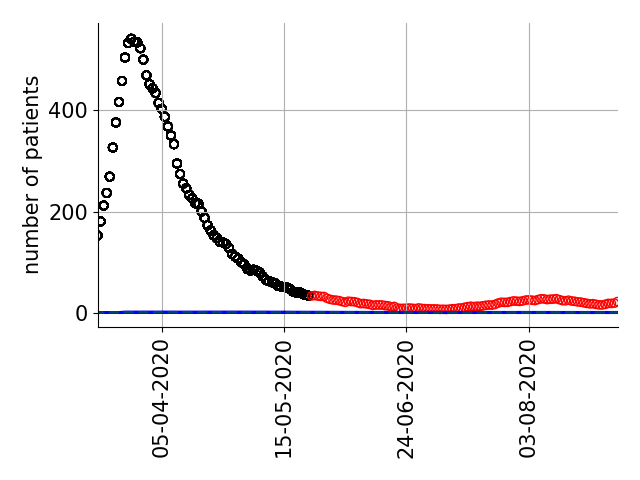

C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


In [22]:
end_date = '2020-09-01'
plot_simulations(start_date, end_ramp, end_date, model_wave1, samples_dict, 
                timeseries, spatial_unit, n_lines=100, save=True)

# Step-by-step calibration

## Simulation until 1 July

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-03.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
samples_dict = samples_dict_wave1

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict_wave1['beta']).hist(ax=ax)

In [ ]:
np.mean(samples_dict_wave1['beta'])

In [ ]:
samples_dict_wave1['lag_time']

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_july = model.sim(time='2020-07-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_july.isel(time=-1).mean(dim="draws")
initial_states_july1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', initial_states_july1)

## Calibration month July

In [ ]:
initial_states_july1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-07-01'
end_beta = '2020-08-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_july = models.COVID19_SEIRD(initial_states_july1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_July'

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
samples_dict = full_calibration_wave2(model_july, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None,None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model_july.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_july.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

## Simulation until 1 August

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_July_2020-10-30.json', 'r') as fp:
    samples_dict_july = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_aug = model_july.sim(time='2020-08-01', excess_time=0,start_date='2020-07-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_july)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', initial_states_aug1)

## Calibration month August

In [ ]:
initial_states_aug1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-09-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Aug'

In [ ]:
beta_init = np.mean(samples_dict_july['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_july['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on july!
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
## Deze herrunnen!
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict_aug['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

## Simulation until 1 September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_Aug_2020-10-30.json', 'r') as fp:
    samples_dict_aug = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_sept = model_aug.sim(time='2020-09-01', excess_time=0,start_date='2020-08-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_aug)
states = out_sept.isel(time=-1).mean(dim="draws")
initial_states_sept1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', initial_states_sept1)

In [ ]:
initial_states_sept1

## Calibration month September

In [ ]:
initial_states_sept1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-09-01'
end_beta = '2020-10-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_sept = models.COVID19_SEIRD(initial_states_sept1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Sept'

In [ ]:
beta_init = 0.03
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_aug['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on aug!
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_sept.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_sept.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration on October

## Simulation until end September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Hainaut_wave1_2020-11-03.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
states = [['H_in']]
end_date = '2020-09-28'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict_wave1['l'])))
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]
    model.parameters['policy_time'] = samples_dict_wave1['warmup']
    model.parameters['prevention'] = samples_dict_wave1['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict_wave1['warmup'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict_wave1['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', end_date)

In [ ]:
out_sept28 = model.sim(time='2020-09-28', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=10, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_sept28.isel(time=-1).mean(dim="draws")
initial_states_sept28 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
out_sept28.isel(time=-1).mean(dim="draws")

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', initial_states_sept28)

## Calibration starting September 28

In [ ]:
initial_states_sept28 = np.load('../data/interim/prediction_provinces/Hainaut_initial_states_Sept28.npy', allow_pickle=True).item()

In [ ]:
initial_states_sept28

In [ ]:
# Second wave
start_date = '2020-09-28'
end_beta = '2020-10-30'

In [ ]:
len(Hainaut_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model = models.COVID19_SEIRD(initial_states_sept28, params)

In [ ]:
# function parameters 
timeseries = Hainaut_ts['NEW_IN']
spatial_unit = 'Hainaut_wave2_from_sept28'


In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [ ]:
samples_dict = full_calibration_wave2(model, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, 
                                      maxiter=100, popsize=200, steps_mcmc=1000)

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-09-01', '2021-01-01')
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration from August 1

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/provinces/Hainaut_wave1_2020-11-04.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

## Simulation until August 1 with policies

In [ ]:
out_aug1 = model_wave1_with_policies.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Hainaut_initial_states_Aug1.npy', initial_states_aug1)

## Simulation until August 1 without policies

In [ ]:
out_aug1 = model_wave1.sim(time='2020-08-01', excess_time=samples_dict_wave1['warmup'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug1.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/initial_states_provinces/'+spatial_unit+'_Aug1.npy', initial_states_aug1)

## Calibration starting August 1

In [ ]:
initial_states_aug1 = np.load('../data/interim/initial_states_provinces/Hainaut_wave1_Aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-10-31'

In [ ]:
len(Hainaut_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model_wave2_from_aug1 = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])


In [ ]:
spatial_unit = 'Hainaut_wave2_from_aug1_no_policies_10000'
samples_dict = full_calibration_wave2(model_wave2_from_aug1, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total, pso=False,
                                      maxiter=100, popsize=200, steps_mcmc=10000)

In [ ]:
fig, ax = plt.subplots()
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
end_date = '2021-01-01'
plot_simulations(start_date, end_ramp, end_date, model_wave2_from_aug1, samples_dict, 
                timeseries, spatial_unit, n_lines=200, save=True)